In [13]:
# ==============================
# STEP 0: INSTALL & IMPORTS
# ==============================


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [14]:
# ==============================
# STEP 1: LOAD DATA
# ==============================

# ☀️ CHANGE THIS PATH ONLY
FILE_PATH = "ABIDEII_Composite_Phenotypic.csv"

df = pd.read_csv(FILE_PATH, encoding='latin1', engine='python')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1114, 348)


,SITE_ID,SUB_ID,NDAR_GUID,DX_GROUP,PDD_DSM_IV_TR,ASD_DSM_5,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,...,ADI_R_C3_TOTAL,ADI_R_C4_REPETITIVE_USE_OBJECTS,ADI_R_C4_HIGHER,ADI_R_C4_UNUSUAL_SENSORY_INTERESTS,ADI_R_C4_TOTAL,ADI_R_D_AGE_PARENT_NOTICED,ADI_R_D_AGE_FIRST_SINGLE_WORDS,ADI_R_D_AGE_FIRST_PHRASES,ADI_R_D_AGE_WHEN_ABNORMALITY,ADI_R_D_INTERVIEWER_JUDGMENT
0,ABIDEII-BNI_1,29006,NaN,1,NaN,NaN,48.0,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABIDEII-BNI_1,29007,NaN,1,NaN,NaN,41.0,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABIDEII-BNI_1,29008,NaN,1,NaN,NaN,59.0,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABIDEII-BNI_1,29009,NaN,1,NaN,NaN,57.0,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABIDEII-BNI_1,29010,NaN,1,NaN,NaN,45.0,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# ==============================
# STEP 2: TARGET & FEATURE SPLIT
# ==============================

TARGET = "DX_GROUP"   # 1 = ASD, 2 = Control

# Convert target → binary
y = df[TARGET].map({1: 1, 2: 0})

# Drop ID / leakage columns
drop_cols = [
    "DX_GROUP",
    "SUB_ID",
    "FILE_ID",
    "SITE_ID"
]

X = df.drop(columns=[c for c in drop_cols if c in df.columns])

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Features shape: (1114, 345)
Target distribution:
 DX_GROUP
0    593
1    521
Name: count, dtype: int64


In [16]:
# ==============================
# STEP 3: IMPUTATION & ENCODING
# ==============================

num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=["object"]).columns
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# --- Impute numerical columns ---
if not num_cols.empty:
    for col in num_cols:
        # Fill NaNs with the column's median. If all values are NaN, median is NaN, so NaNs remain.
        X[col] = X[col].fillna(X[col].median())

# --- Impute categorical columns ---
if not cat_cols.empty:
    for col in cat_cols:
        # Extract column values as a 2D numpy array, ensuring string type
        col_values = X[col].astype(str).values.reshape(-1, 1)
        # Impute and assign back to the DataFrame as a Series to ensure index alignment
        X.loc[:, col] = pd.Series(cat_imputer.fit_transform(col_values).ravel(), index=X.index)

    # Finally, label encode the imputed categorical columns
    for col in cat_cols:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

print("Preprocessing complete!")

Preprocessing complete!


In [17]:
# ==============================
# STEP 4: SCALING
# ==============================

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
print("Scaling complete!")

Scaling complete!


In [18]:
# ==============================
# STEP 5: TRAIN / TEST SPLIT
# ==============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (891, 345)
Test shape: (223, 345)


In [19]:
# ==============================
# STEP 6: XGBOOST MODEL TRAINING
# ==============================

model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)
print("✅ Model training complete!")

✅ Model training complete!


In [20]:
# ==============================
# STEP 7: EVALUATION
# ==============================

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred) * 100
roc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {acc:.2f}%")
print(f"ROC-AUC: {roc:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 99.10%
ROC-AUC: 0.9984

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       119
           1       0.99      0.99      0.99       104

    accuracy                           0.99       223
   macro avg       0.99      0.99      0.99       223
weighted avg       0.99      0.99      0.99       223



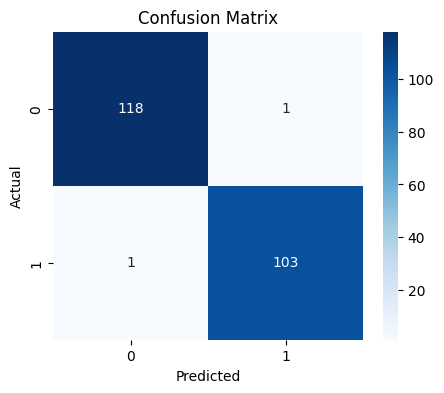

In [21]:
# ==============================
# STEP 8: CONFUSION MATRIX
# ==============================

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

                    Feature  Importance
33            SRS_TOTAL_RAW    0.146779
36    SRS_COMMUNICATION_RAW    0.102202
38       SRS_MANNERISMS_RAW    0.083448
1             PDD_DSM_IV_TR    0.072587
28             ADOS_2_TOTAL    0.026599
44         SRS_MANNERISMS_T    0.025982
14    ADI_R_VERBAL_TOTAL_BV    0.023956
21             ADOS_G_TOTAL    0.020320
26         ADOS_2_SOCAFFECT    0.019497
193    BASC2_PRS_ADAPTIVE_T    0.019320
50       CURRENT_MED_STATUS    0.017680
2                 ASD_DSM_5    0.017082
192  BASC2_PRS_FUNCTIONAL_T    0.016379
49       NONASD_PSYDX_LABEL    0.015332
35        SRS_COGNITION_RAW    0.014815


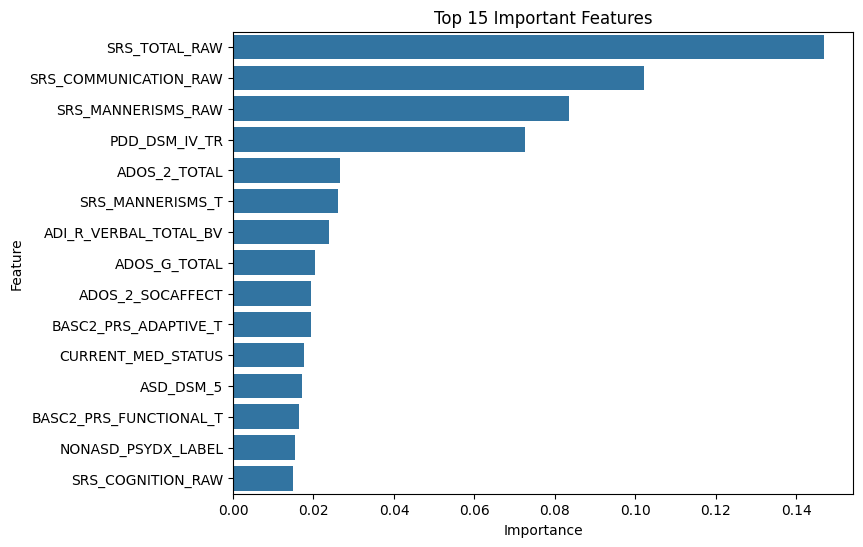

In [22]:
# ==============================
# STEP 9: FEATURE IMPORTANCE
# ==============================

feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feat_imp.head(15))

plt.figure(figsize=(8,6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feat_imp.head(15)
)
plt.title("Top 15 Important Features")
plt.show()

In [23]:
# ==============================
# STEP 10: 5-FOLD CROSS VALIDATION
# ==============================

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    clf = XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )

    clf.fit(X_tr, y_tr)
    preds = clf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    cv_acc.append(acc)

    print(f"Fold {fold} Accuracy: {acc:.4f}")

print("\nMean CV Accuracy:", np.mean(cv_acc))

Fold 1 Accuracy: 0.9821
Fold 2 Accuracy: 0.9910
Fold 3 Accuracy: 0.9641
Fold 4 Accuracy: 0.9731
Fold 5 Accuracy: 0.9910

Mean CV Accuracy: 0.9802609784672563


In [24]:
# ==============================
# STEP 11: SAVE MODEL
# ==============================

import pickle

# Save the complete sklearn model with pickle
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ XGBoost model saved as xgboost_model.pkl")

✅ XGBoost model saved as xgboost_model.pkl
